In [ ]:
# Let's simulate the data ofb sequential composition for the fixed structure of the modules and compute E[Y(1)], as well as E[Y_{1}(1)] and E[Y_{2}(1)]. and see if expectations can be composed together. 

# Main 

In [8]:
import argparse
import json
import os
import warnings
import sys
sys.path.append('../')

import pandas as pd
from sklearn.metrics import r2_score

from domains.samplers import SyntheticDataSampler
from models.MoE import *
from models.utils import *
from models.additive_parallel_comp_model import *
warnings.filterwarnings('ignore')


import argparse
import json
import os
import warnings
import pandas as pd
from sklearn.metrics import r2_score
from domains.samplers import SyntheticDataSampler
from models.MoE import *
from models.utils import *
from models.additive_parallel_comp_model import get_additive_model_effects


def parse_arguments(jupyter=False):
    parser = argparse.ArgumentParser(description="Train modular neural network architectures and baselines for causal effect estimation")
    parser.add_argument("--domain", type=str, default="synthetic_data", help="Domain")
    parser.add_argument("--biasing_covariate", type=str, default="feature_sum", help="Biasing covariate")
    parser.add_argument("--bias_strength", type=float, default=10, help="Bias strength")
    parser.add_argument("--scale", type=bool, default=False, help="Scale data")
    parser.add_argument("--num_modules", type=int, default=3, help="Number of modules")
    parser.add_argument("--num_feature_dimensions", type=int, default=2, help="Number of feature dimensions")
    parser.add_argument("--num_samples", type=int, default=10000, help="Number of samples")
    parser.add_argument("--module_function_type", type=str, default="quadratic", help="Module function type")
    parser.add_argument("--composition_type", type=str, default="hierarchical", help="Composition type")
    parser.add_argument("--resample", type=bool, default=True, help="Resample data")
    parser.add_argument("--seed", type=int, default=45, help="Seed for reproducibility")
    parser.add_argument("--fixed_structure", type=bool, default=True, help="Fixed structure flag")
    parser.add_argument("--data_dist", type=str, default="uniform", help="Data distribution")
    parser.add_argument("--heterogeneity", type=float, default=1.0, help="Heterogeneity")
    parser.add_argument("--split_type", type=str, default="ood", help="Split type")
    # hidden_dim
    parser.add_argument("--hidden_dim", type=int, default=64, help="Hidden dimension")
    # epochs
    parser.add_argument("--epochs", type=int, default=100, help="Number of epochs")
    # batch_size
    parser.add_argument("--batch_size", type=int, default=64, help="Batch size")
    # output_dim
    parser.add_argument("--output_dim", type=int, default=1, help="Output dimension")
    # covariates_shared
    parser.add_argument("--covariates_shared", type=bool, default=False, help="Covariates shared")
    # model_class
    parser.add_argument("--underlying_model_class", type=str, default="MLP", help="Model class")
    # run_env
    parser.add_argument("--run_env", type=str, default="local", help="Run environment")
    # use_subset_features
    parser.add_argument("--use_subset_features", type=bool, default=False, help="Use subset features")
    # generate trees systematically for creating OOD data
    parser.add_argument("--systematic", type=bool, default=True, help="Generate trees systematically")
    parser.add_argument("--test_size", type=float, default=0.2, help="Test size")
    parser.add_argument("--model_misspecification", type=bool, default=True, help="Hide some features from the model")


    if jupyter:
        args = parser.parse_args([])
    else:
        args = parser.parse_args()
    return args

def setup_directories(args):
    base_dir = "/Users/ppruthi/research/compositional_models/compositional_models_cate/domains" if args.run_env == "local" else "/work/pi_jensen_umass_edu/ppruthi_umass_edu/compositional_models_cate/domains"
    main_dir = f"{base_dir}/{args.domain}"
    csv_path = f"{main_dir}/csvs/fixed_structure_{args.fixed_structure}_outcomes_{args.composition_type}_systematic_{args.systematic}"
    obs_data_path = f"{main_dir}/observational_data/fixed_structure_{args.fixed_structure}_outcomes_{args.composition_type}_systematic_{args.systematic}"
    scaler_path = f"{obs_data_path}/{args.biasing_covariate}_{args.bias_strength}/{args.split_type}/scalers"
    return main_dir, csv_path, obs_data_path, scaler_path

def simulate_and_prepare_data(args, sampler, csv_path, obs_data_path, scaler_path, test_size=0.2, test_on_last_depth=False):
    if args.resample:
        sampler.simulate_data()
    sampler.create_observational_data(biasing_covariate=args.biasing_covariate, bias_strength=args.bias_strength)
    sampler.create_iid_ood_split(split_type=args.split_type, test_size=test_size, test_on_last_depth=test_on_last_depth)
        
    data = pd.read_csv(f"{csv_path}/{args.domain}_data_high_level_features.csv")
    df_sampled = pd.read_csv(f"{obs_data_path}/{args.biasing_covariate}_{args.bias_strength}/df_sampled.csv")
    
    return data, df_sampled

def load_train_test_qids(csv_path, args):
    with open(f"{csv_path}/{args.split_type}/train_test_split_qids.json", "r") as f:
        train_test_qids = json.load(f)
    train_qids, test_qids = train_test_qids["train"], train_test_qids["test"]
    return train_qids, test_qids

def load_train_test_data(csv_path, args, df_sampled):
    train_qids, test_qids = load_train_test_qids(csv_path, args)
    train_df = df_sampled[df_sampled["query_id"].isin(train_qids)]
    test_df = df_sampled[df_sampled["query_id"].isin(test_qids)]
    return train_df, test_df, train_qids, test_qids

def train_and_evaluate_model(model, train_df, test_df, covariates, treatment, outcome, epochs, batch_size, train_qids, test_qids):
    model, _, _ = train_model(model, train_df, covariates, treatment, outcome, epochs, batch_size)
    train_estimates = predict_model(model, train_df, covariates)
    test_estimates = predict_model(model, test_df, covariates)
    train_df.loc[:, "estimated_effect"] = train_estimates
    test_df.loc[:, "estimated_effect"] = test_estimates
    estimated_effects_train = get_estimated_effects(train_df, train_qids)
    estimated_effects_test = get_estimated_effects(test_df, test_qids)
    return estimated_effects_train, estimated_effects_test

def train_and_evaluate_catenets(train_df, test_df, covariates, treatment, outcome, train_qids, test_qids):
    model = train_catenets(train_df, covariates, treatment, outcome)
    train_estimates = predict_catenets(model, train_df, covariates)
    test_estimates = predict_catenets(model, test_df, covariates)
    train_df.loc[:, "estimated_effect"] = train_estimates
    test_df.loc[:, "estimated_effect"] = test_estimates
    estimated_effects_train = get_estimated_effects(train_df, train_qids)
    estimated_effects_test = get_estimated_effects(test_df, test_qids)
    return estimated_effects_train, estimated_effects_test

def calculate_metrics(gt_effects, estimated_effects):
    pehe_score = pehe(gt_effects, estimated_effects)
    r2_score_val = r2_score(gt_effects, estimated_effects)
    return pehe_score, r2_score_val

def decompose_module_errors(module_csvs, num_modules):
    module_dfs = {}
    module_wise_pehe = []
    cov = {}
    print(module_csvs.keys())

    for module_file, module_csv in module_csvs.items():
        module_id = int(module_file.split("_")[-1])
        print(f"Module {module_id}")
        module_dfs[module_id] = module_csv
        pehe_score = pehe(module_csv['ground_truth_effect'], module_csv['estimated_effect'])
        a = module_csv['ground_truth_effect']
        b = module_csv['estimated_effect']
        module_wise_pehe.append(pehe_score)
        cov[module_id] = a - b

    total_cov = []
    for i in range(1, num_modules + 1):
        for j in range(1, num_modules + 1):
            if i != j:
                total_cov.append(np.mean(cov[i] * cov[j]))

    return  sum(module_wise_pehe), sum(total_cov)


def process_shared_covariates_row_wise(train_df, test_df, args):
    num_modules = [col for col in train_df.columns if col.startswith('num_module_')]
    if args.covariates_shared and args.composition_type == "parallel":
        def process_row(row):
            # Find non-zero modules for this row
            num_modules = [col for col in row.index if col.startswith('num_module_')]
            non_zero_modules = [int(col.split('_')[-1]) for col in num_modules if row[col] != 0]
            first_module = non_zero_modules[0]
            first_module_features = [col for col in row.index if col.startswith(f'module_{first_module}_feature_')]
            if not non_zero_modules:
                raise ValueError(f"No non-zero modules found for row with query_id {row['query_id']}")
            
            # Create a new row with renamed features
            new_row = {}
            for feature in first_module_features:
                feature_id = int(feature.split('_')[-1])
                new_row[f'feature_{feature_id}'] = row[feature]
            
            # Add other necessary columns
            for col in ['query_id', 'treatment_id', 'tree_depth', 'query_output'] + num_modules:
                new_row[col] = row[col]
            
            return pd.Series(new_row)

        # don't include header row
        train_df_processed = train_df.apply(process_row, axis=1)
        test_df_processed = test_df.apply(process_row, axis=1)
        print(f"Train data shape: {train_df_processed.shape}")
        print(f"Test data shape: {test_df_processed.shape}")
        
        
        # Ensure consistent column ordering
        columns_order = [col for col in train_df_processed.columns if col.startswith('feature_')] + ['query_id', 'treatment_id', 'tree_depth', 'query_output'] + num_modules
        train_df_processed = train_df_processed[columns_order]
        test_df_processed = test_df_processed[columns_order]
        
        return train_df_processed, test_df_processed
    else:
        # If covariates are not shared, return the original dataframes
        return train_df, test_df

def combine_model_effects(gt_effects, model_effects, additive_combined_df):
    """
    Combine ground truth effects with estimated effects from all models into a single DataFrame.
    
    :param gt_effects: Dictionary of ground truth effects
    :param model_effects: Dictionary of estimated effects for each model
    :param additive_combined_df: DataFrame with additive model results
    :return: Combined DataFrame with effects from all models
    """
    # Start with ground truth effects
    combined_df = pd.DataFrame({
        'query_id': gt_effects.keys(),
        'ground_truth_effect': gt_effects.values()
    })
    
    # Add effects from each model
    for model_name, effects in model_effects.items():
        combined_df[f'{model_name}_effect'] = [effects[qid] for qid in combined_df['query_id']]
    
    # Add effects from the additive model
    additive_effects = additive_combined_df.set_index('query_id')['estimated_effect']
    additive_gt_effects = additive_combined_df.set_index('query_id')['ground_truth_effect']
    combined_df['Additive_effect'] = combined_df['query_id'].map(additive_effects)
    combined_df['Additive_gt_effect'] = combined_df['query_id'].map(additive_gt_effects)
    
    return combined_df

all_results = {}
all_results_train_size = {}
# test_sizes = [0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
test_sizes = [0.2]
for test_size in test_sizes:
    all_results[test_size] = {}
    all_results_train_size[test_size] = []
    args = parse_arguments()
    args.test_size = test_size
    main_dir, csv_path, obs_data_path, scaler_path = setup_directories(args)
    # module_function_types = ["logarithmic", "quadratic", "linear"]
    # module_function_types = ["polyval"] * args.num_modules
    module_function_types = [f"f{i+1}" for i in range(args.num_modules)]
    sampler = SyntheticDataSampler(args.num_modules, args.num_feature_dimensions, args.composition_type, 
                                    args.fixed_structure, args.num_modules, args.num_samples, args.seed, 
                                    args.data_dist, module_function_types=module_function_types, resample=args.resample,
                                    heterogeneity=args.heterogeneity, covariates_shared=args.covariates_shared, 
                                    use_subset_features=args.use_subset_features, systematic=args.systematic, 
                                    run_env=args.run_env)

    # first sample the data and prepare it
    data, df_sampled = simulate_and_prepare_data(args, sampler, csv_path, obs_data_path, scaler_path, test_size=test_size, test_on_last_depth=True)
    if args.composition_type == "hierarchical":
        # order_of_modules is a string "2_3_1", convert it to a list [2, 3, 1] and make it separate columns
        data["order_of_modules"] = data["order_of_modules"].apply(lambda x: [int(i) for i in x.split("_")])
        data = pd.concat([data, pd.DataFrame(data["order_of_modules"].to_list(), columns=[f"module_{i+1}_order" for i in range(args.num_modules)])], axis=1)

        df_sampled["order_of_modules"] = df_sampled["order_of_modules"].apply(lambda x: [int(i) for i in x.split("_")])
        df_sampled = pd.concat([df_sampled, pd.DataFrame(df_sampled["order_of_modules"].to_list(), columns=[f"module_{i+1}_order" for i in range(args.num_modules)])], axis=1)

        # get the order of modules per query_id
        module_order = {}
        for qid, order in zip(df_sampled["query_id"], df_sampled["order_of_modules"]):
            module_order[qid] = order

        # drop the order_of_modules column
        data.drop(columns=["order_of_modules"], inplace=True)
        df_sampled.drop(columns=["order_of_modules"], inplace=True)

        if args.systematic:
            # replace NaN module orders with 0
            for i in range(1, args.num_modules + 1):
                data[f"module_{i}_order"].fillna(0, inplace=True)
                df_sampled[f"module_{i}_order"].fillna(0, inplace=True)

        

    # Load train and test qids
    train_qids, test_qids = load_train_test_qids(csv_path, args)

    # Scale data
    if args.scale:
        create_module_scalers(csv_path, obs_data_path, scaler_path, train_qids, args.bias_strength)
        data, df_sampled = scale_df(data, df_sampled, scaler_path, csv_path)

    # Load train and test data
    train_df, test_df, train_qids, test_qids = load_train_test_data(csv_path, args, df_sampled)

    train_df, test_df = process_shared_covariates_row_wise(train_df, test_df, args)
    # covariates = [x for x in train_df.columns if "feature" or "order" in x and "output" not in x]


    covariates = [x for x in train_df.columns if "feature_0" in x] if args.covariates_shared else [x for x in train_df.columns if "feature" in x]
    
        # remove any output features
        
    if args.systematic:
        covariates += [x for x in train_df.columns if "num" in x]

    if args.composition_type == "hierarchical":
        covariates += [x for x in train_df.columns if "order" in x]
        # covariates = [x for x in covariates if "output" not in x]

    if args.model_misspecification:
        covariates = [x for x in covariates if "feature_0" not in x]

    print(f"Training data shape: {train_df.shape}")
    print("Covaariates: ", covariates)
    treatment, outcome = "treatment_id", "query_output"

    gt_effects_test = get_ground_truth_effects(data, test_qids)
    gt_effects_train = get_ground_truth_effects(data, train_qids)


    model_effects_train = {}
    model_effects_test = {}

    input_dim = len(covariates)
    if input_dim < args.hidden_dim and args.covariates_shared:
        hidden_dim = args.hidden_dim 
    else:
        hidden_dim = (input_dim + 1)*2
    models = {
        "Baseline": BaselineModel if args.underlying_model_class == "MLP" else BaselineLinearModel,
        "MoE": MoE if args.underlying_model_class == "MLP" else MoELinear
    }

    results = {}
    for model_name, model_class in models.items():
        print(f"Training {model_name} Model")
        if model_name == "Baseline":
            model = model_class(input_dim + 1, hidden_dim, args.output_dim)
        else:
            model = model_class(input_dim + 1, hidden_dim, args.output_dim, args.num_modules)
        
        estimated_effects_train, estimated_effects_test = train_and_evaluate_model(
            model, train_df, test_df, covariates, treatment, outcome, args.epochs, args.batch_size, train_qids, test_qids
        )
        gt_effects_train_values, gt_effects_test_values = np.array(list(gt_effects_train.values())), np.array(list(gt_effects_test.values()))
        estimated_effects_train_values, estimated_effects_test_values = np.array(list(estimated_effects_train.values())), np.array(list(estimated_effects_test.values()))
        results[f"{model_name}_train"] = calculate_metrics(gt_effects_train_values, estimated_effects_train_values)
        results[f"{model_name}_test"] = calculate_metrics(gt_effects_test_values, estimated_effects_test_values)
        model_effects_train[model_name] = estimated_effects_train
        model_effects_test[model_name] = estimated_effects_test


    # # Catenets
    # print("Training Catenets Model")
    # estimated_effects_train, estimated_effects_test = train_and_evaluate_catenets(train_df, test_df, covariates, treatment, outcome, train_qids, test_qids)
    # gt_effects_train_values, gt_effects_test_values = np.array(list(gt_effects_train.values())), np.array(list(gt_effects_test.values()))
    # estimated_effects_train_values, estimated_effects_test_values = np.array(list(estimated_effects_train.values())), np.array(list(estimated_effects_test.values()))
    # results["Catenets_train"] = calculate_metrics(gt_effects_train_values, estimated_effects_train_values)
    # results["Catenets_test"] = calculate_metrics(gt_effects_test_values, estimated_effects_test_values)
    # # Add Catenets effects
    # model_effects_train["Catenets"] = estimated_effects_train
    # model_effects_test["Catenets"] = estimated_effects_test
        
    # print("Training Sequential Model")
    # Call the sequential model function
    sequential_train_df, sequential_test_df = get_sequential_model_effects(
        csv_path, obs_data_path, train_qids, test_qids, module_order,
        hidden_dim=args.hidden_dim, epochs=args.epochs, 
        batch_size=args.batch_size, output_dim=args.output_dim,
        underlying_model_class=args.underlying_model_class, scale=args.scale,
        scaler_path=scaler_path, bias_strength=args.bias_strength,
        domain=args.domain, model_misspecification=args.model_misspecification
    )

    # Calculate metrics for the sequential model
    
    results["Sequential_train"] = calculate_metrics(sequential_train_df["ground_truth_effect"], sequential_train_df["estimated_effect"])
    results["Sequential_test"] = calculate_metrics(sequential_test_df["ground_truth_effect"], sequential_test_df["estimated_effect"])

    # # Save results and CSVs
    # results_path = f"{main_dir}/results/systematic_{args.systematic}/results_{args.data_dist}_{args.composition_type}_covariates_shared_{args.covariates_shared}_use_subset_features_{args.use_subset_features}_test_size_{test_size}"
    # os.makedirs(results_path, exist_ok=True)
    # with open(f"{results_path}/results_{args.num_modules}_{args.num_feature_dimensions}_scale_{args.scale}.json", "w") as f:
    #     json.dump(results, f)

    results_csv_folder = f"{results_path}/csvs_{args.num_modules}_{args.num_feature_dimensions}_scale_{args.scale}"
    os.makedirs(results_csv_folder, exist_ok=True)

    # Save CSVs
    sequential_train_df.to_csv(f"{results_csv_folder}/sequential_combined_train_df.csv", index=False)
    sequential_test_df.to_csv(f"{results_csv_folder}/sequential_combined_test_df.csv", index=False)

    # Create combined DataFrames (assuming these functions are still relevant for sequential model)
    combined_df_train = combine_model_effects(gt_effects_train, model_effects_train, sequential_train_df)
    combined_df_test = combine_model_effects(gt_effects_test, model_effects_test, sequential_test_df)

    # Save combined DataFrames
    combined_df_train.to_csv(f"{results_csv_folder}/combined_effects_train.csv", index=False)
    combined_df_test.to_csv(f"{results_csv_folder}/combined_effects_test.csv", index=False)

    print(results)
    print(f"Results saved at {results_path}")
    print(f"CSVs saved at {results_csv_folder}")
    print("Done!")

    all_results[test_size] = results
    all_results_train_size[test_size] = [sequential_train_df.shape[0], [len(sequential_train_df[sequential_train_df['query_id'].isin(qids)]) for qids in module_order.values()]]

num_modules:  3
Reinitializing path 0
Reinitializing path 1
Reinitializing csv folder
Resampling data
Generating input trees
Generating input trees
Generating trees for group size: 2
Number of combinations: 3
Group size: 2, Number of trees: 1998
Generating trees for group size: 3
Number of combinations: 1
Group size: 2, Number of trees: 1998
Group size: 3, Number of trees: 2000
Number of input trees generated: 3998
Simulating potential outcomes for treatment 0
Simulating potential outcomes for treatment 1
Writing CSV data to files for each module.
train depths:  [2]
test depths:  [3]
Training data shape: (1998, 22)
Covaariates:  ['module_1_feature_feature_1', 'module_1_feature_child_output', 'module_2_feature_feature_1', 'module_2_feature_child_output', 'module_3_feature_feature_1', 'module_3_feature_child_output', 'num_module_1', 'num_module_2', 'num_module_3', 'module_1_order', 'module_2_order', 'module_3_order']
Training Baseline Model
Training the model on cpu
(1998, 13)
Training M

TypeError: Object of type ndarray is not JSON serializable

In [9]:
combined_df_train = combine_model_effects(gt_effects_train, model_effects_train, sequential_train_df)
combined_df_test = combine_model_effects(gt_effects_test, model_effects_test, sequential_test_df)

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [7]:
results

{'Baseline_train': (0.563576774234618, 0.8497187566304509),
 'Baseline_test': (1.6914081664771479, 0.6349307806961133),
 'MoE_train': (0.6871349559882921, 0.8167712008912346),
 'MoE_test': (0.9592293638813935, 0.7929623836835865),
 'Sequential_train': (array([0.9640827], dtype=float32), -1.1634456156546462),
 'Sequential_test': (array([0.98589575], dtype=float32), -1.1703021885280873)}

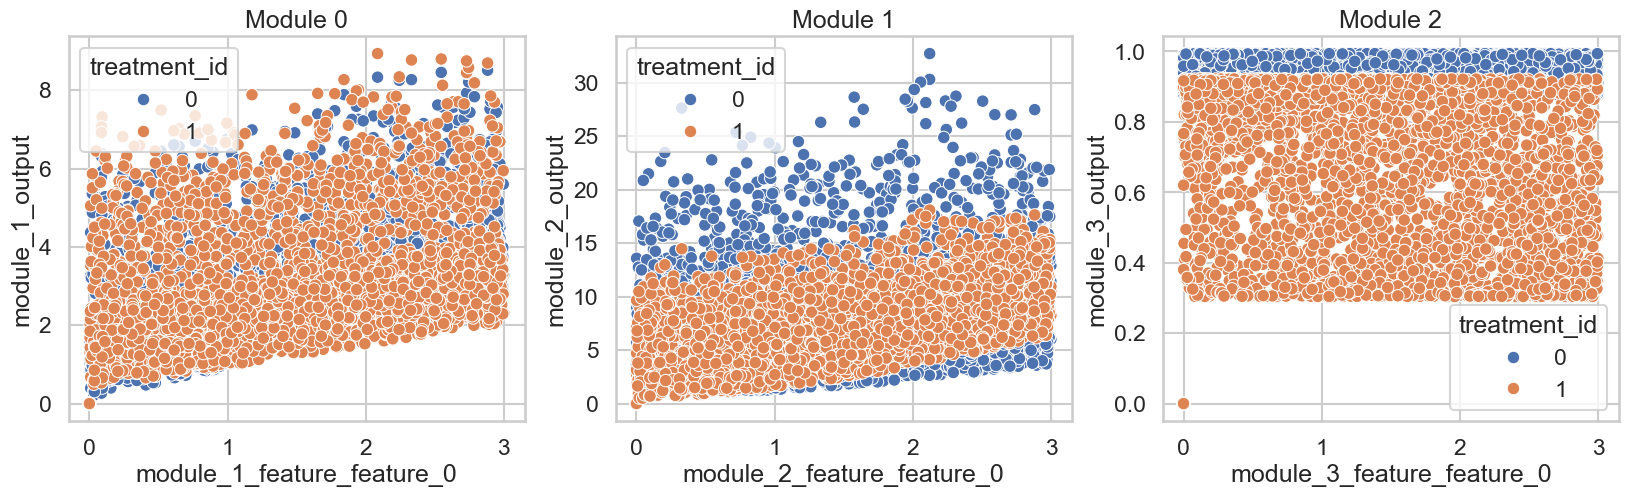

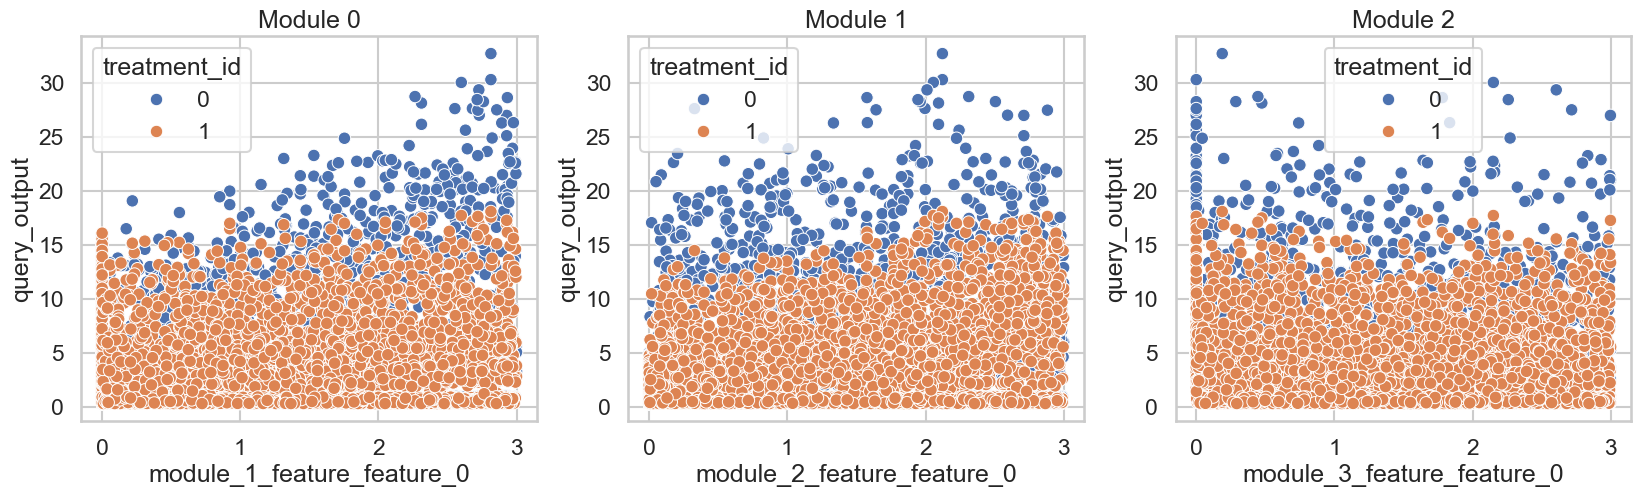

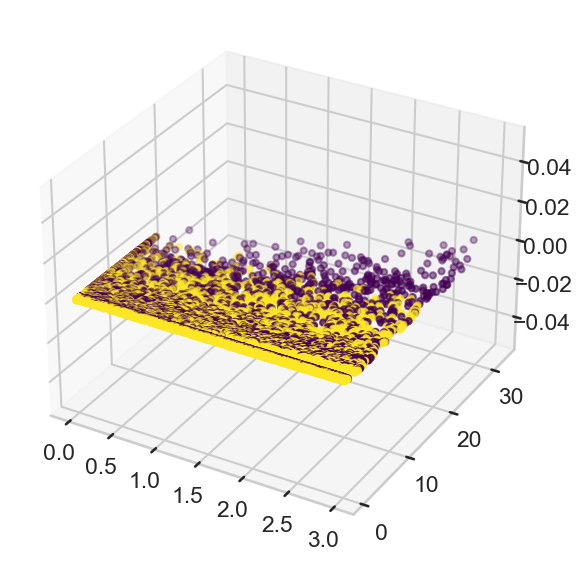

In [28]:
# Hypotheses to test
# 1. Each component output is a quadratic function of the input features.
# 2. Plot final output vs input features.

# Hypothesis 1
# plot 1
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("talk")
max_modules = args.num_modules
fig, ax = plt.subplots(1, max_modules, figsize=(20, 5))
for i in range(max_modules):
    sns.scatterplot(x=f"module_{i+1}_feature_feature_0", y=f"module_{i+1}_output", data=data, ax=ax[i],hue="treatment_id")
    ax[i].set_title(f"Module {i}")

fig, ax = plt.subplots(1, max_modules, figsize=(20, 5))
for i in range(max_modules):
    sns.scatterplot(x=f"module_{i+1}_feature_feature_0", y=f"query_output", data=data, ax=ax[i],hue="treatment_id")
    ax[i].set_title(f"Module {i}")

# Have a 3D plot for two features and one output
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data["module_1_feature_feature_0"], data["query_output"], c=data["treatment_id"], cmap='viridis')



In [29]:
covariates

['module_1_feature_feature_0',
 'module_1_feature_feature_1',
 'module_1_feature_child_output',
 'module_2_feature_feature_0',
 'module_2_feature_feature_1',
 'module_2_feature_child_output',
 'module_3_feature_feature_0',
 'module_3_feature_feature_1',
 'module_3_feature_child_output',
 'num_module_1',
 'num_module_2',
 'num_module_3',
 'module_1_order',
 'module_2_order',
 'module_3_order']

In [9]:
args.num_modules

10

[0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[1.9999999999999996, 3.0000000000000004, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
[0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[1.9999999999999996, 3.0000000000000004, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
[0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[1.9999999999999996, 3.0000000000000004, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
[0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[1.9999999999999996, 3.0000000000000004, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]


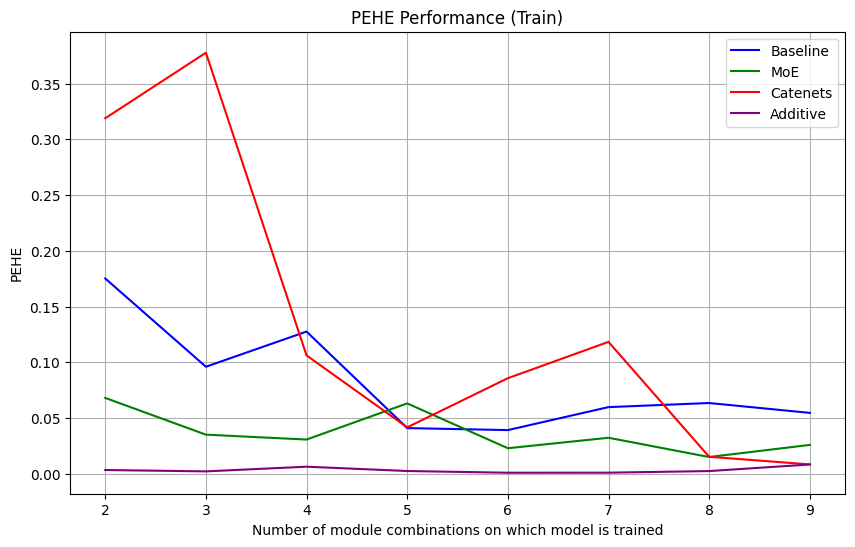

[0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[1.9999999999999996, 3.0000000000000004, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
[0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[1.9999999999999996, 3.0000000000000004, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
[0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[1.9999999999999996, 3.0000000000000004, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
[0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[1.9999999999999996, 3.0000000000000004, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]


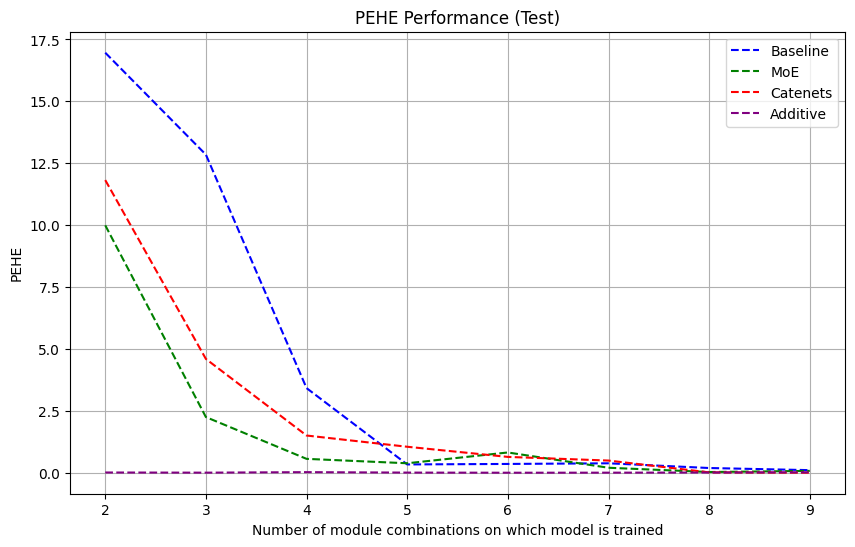

[0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[1.9999999999999996, 3.0000000000000004, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
[0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[1.9999999999999996, 3.0000000000000004, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
[0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[1.9999999999999996, 3.0000000000000004, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
[0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[1.9999999999999996, 3.0000000000000004, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]


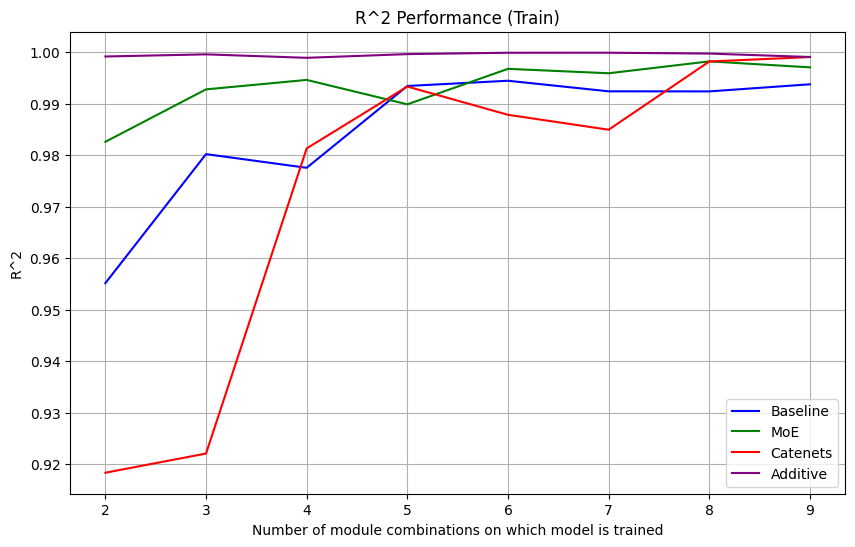

[0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[1.9999999999999996, 3.0000000000000004, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
[0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[1.9999999999999996, 3.0000000000000004, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
[0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[1.9999999999999996, 3.0000000000000004, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
[0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[1.9999999999999996, 3.0000000000000004, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]


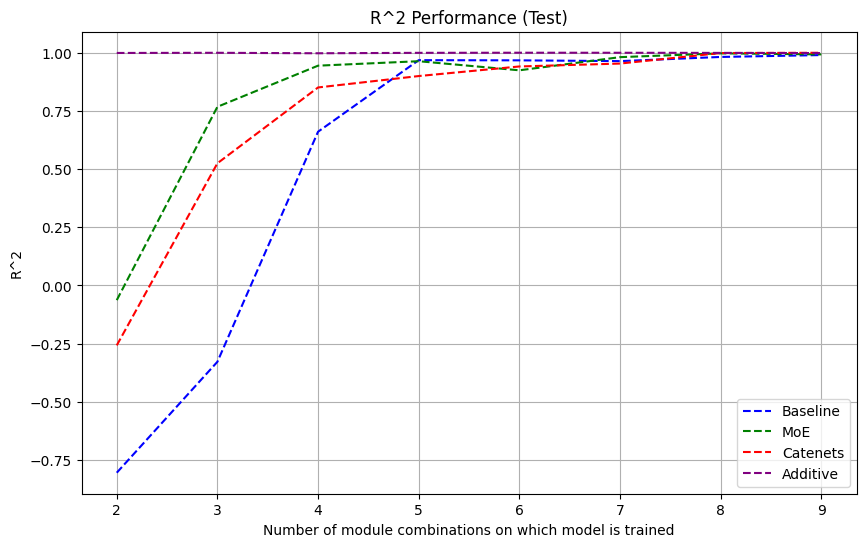

In [17]:
# Colors for each model
import math
colors = {
    'Baseline': 'blue',
    'MoE': 'green',
    'Catenets': 'red',
    'Additive': 'purple'
}

# Function to plot performance
def plot_performance(metric, metric_name, data_type):
    plt.figure(figsize=(10, 6))
    x = list(all_results.keys())
   
    
    for model in ['Baseline', 'MoE', 'Catenets', 'Additive']:
        y = [all_results[key][f'{model}_{data_type}'][metric] for key in x]
        x_plot = 1-np.array(x)
        print(x_plot)
        x_plot = [i*10 for i in x_plot]
        print(x_plot)
        plt.plot(x_plot, y, color=colors[model], label=model, 
                 linestyle='-' if data_type == 'train' else '--')
    
    plt.xlabel('Number of module combinations on which model is trained')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} Performance ({data_type.capitalize()})')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot PEHE for train and test
plot_performance(0, 'PEHE', 'train')
plot_performance(0, 'PEHE', 'test')

# Plot R^2 for train and test
plot_performance(1, 'R^2', 'train')
plot_performance(1, 'R^2', 'test')

In [11]:
x_plot

NameError: name 'x_plot' is not defined

In [12]:
# divide query output by number of non-zero modules
# divide query output by number of non-zero modules
num_modules = [col for col in train_df.columns if col.startswith('num_module_')]
train_df['query_output'] = train_df['query_output'] / train_df[num_modules].sum(axis=1)
test_df['query_output'] = test_df['query_output'] / test_df[num_modules].sum(axis=1)

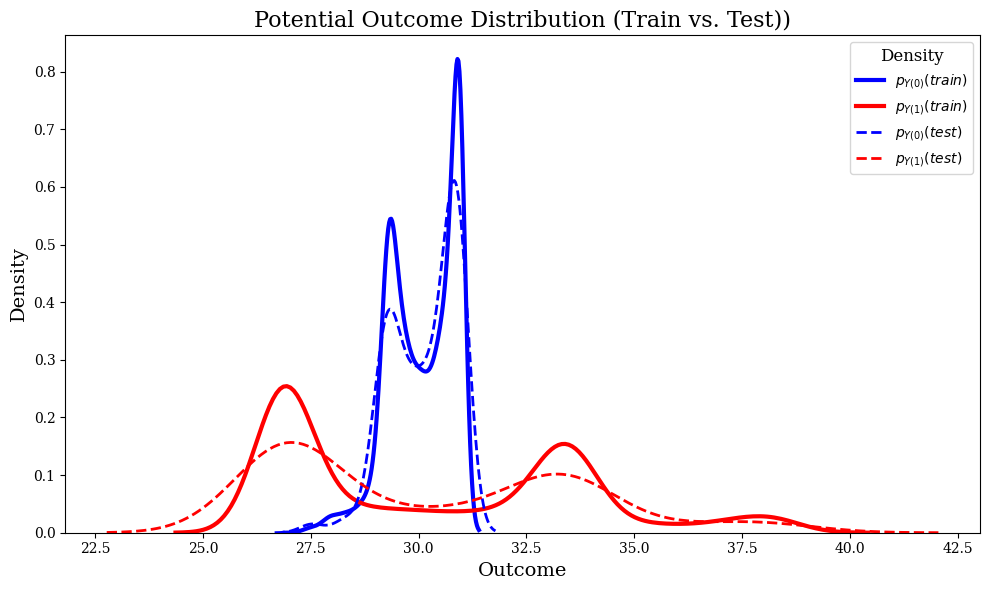

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style and enable LaTeX
plt.rcParams.update({
    "font.family": "serif",
})

# Create the figure
plt.figure(figsize=(10, 6))

# Define colors for treatments
colors = ['blue', 'red']  # blue for p_0, red for p_1

# Plot density for train data (bold lines)
for treatment in [0, 1]:
    if treatment == 0:
        label = r'${p_{Y(0)}}(train)$'
    else:
        label = r'${p_{Y(1)}}(train)$'
    sns.kdeplot(data=train_df[train_df['treatment_id'] == treatment], 
                x='query_output', color=colors[treatment], 
                linestyle='-', linewidth=3,  # Bold line
                label=label)

# Plot density for test data (dashed lines)

for treatment in [0, 1]:
    if treatment == 0:
        label = r'${p_{Y(0)}}(test)$'
    else:
        label = r'${p_{Y(1)}}(test)$'
    sns.kdeplot(data=test_df[test_df['treatment_id'] == treatment], 
                x='query_output', color=colors[treatment], 
                linestyle='--', linewidth=2,  # Dashed line
                label=label)

# Set title and labels
plt.title("Potential Outcome Distribution (Train vs. Test))", fontsize=16)
plt.xlabel("Outcome", fontsize=14)
plt.ylabel("Density", fontsize=14)

# Add legend
plt.legend(title='Density', title_fontsize=12, fontsize=10)

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# Show the plot
plt.show()

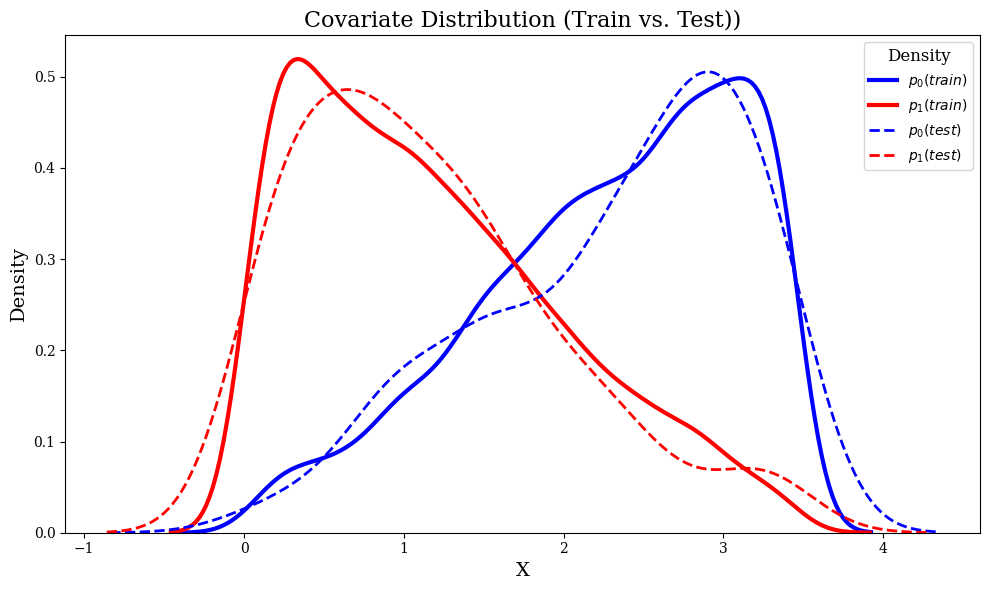

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style and enable LaTeX
plt.rcParams.update({
    "font.family": "serif",
})

# Create the figure
plt.figure(figsize=(10, 6))

# Define colors for treatments
colors = ['blue', 'red']  # blue for p_0, red for p_1

# Plot density for train data (bold lines)
for treatment in [0, 1]:
    if treatment == 0:
        label = r'${p_0}(train)$'
    else:
        label = r'${p_1}(train)$'
    sns.kdeplot(data=train_df[train_df['treatment_id'] == treatment], 
                x='feature_0', color=colors[treatment], 
                linestyle='-', linewidth=3,  # Bold line
                label=label)

# Plot density for test data (dashed lines)

for treatment in [0, 1]:
    if treatment == 0:
        label = r'${p_0}(test)$'
    else:
        label = r'${p_1}(test)$'
    sns.kdeplot(data=test_df[test_df['treatment_id'] == treatment], 
                x='feature_0', color=colors[treatment], 
                linestyle='--', linewidth=2,  # Dashed line
                label=label)

# Set title and labels
plt.title("Covariate Distribution (Train vs. Test))", fontsize=16)
plt.xlabel(r'X', fontsize=14)
plt.ylabel("Density", fontsize=14)

# Add legend
plt.legend(title='Density', title_fontsize=12, fontsize=10)

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# Show the plot
plt.show()

In [28]:
train_df

,feature_0,query_id,treatment_id,tree_depth,query_output,num_module_1,num_module_2,num_module_3,num_module_4,num_module_5,num_module_6,num_module_7,num_module_8,num_module_9,num_module_10,estimated_effect
0,3.287332,0.0,0.0,2.0,7.450842,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.721162
1,1.386121,1.0,1.0,2.0,2.614076,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.935652
2,1.449184,2.0,0.0,2.0,3.555470,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.946573
3,1.830773,3.0,1.0,2.0,3.415209,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.963807
4,3.214268,4.0,0.0,2.0,7.283298,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.725684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1975,1.817987,1975.0,1.0,2.0,6.256585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.788571
1976,1.355247,1976.0,1.0,2.0,5.394947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.306489
1977,0.834129,1977.0,1.0,2.0,4.640085,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.143926
1978,1.245059,1978.0,1.0,2.0,5.219637,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.202561


In [29]:
test_df

,feature_0,query_id,treatment_id,tree_depth,query_output,num_module_1,num_module_2,num_module_3,num_module_4,num_module_5,num_module_6,num_module_7,num_module_8,num_module_9,num_module_10,estimated_effect
1980,2.024449,1980.0,1.0,3.0,8.371116,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.675675
1981,1.386121,1981.0,0.0,3.0,5.545832,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.567783
1982,1.449184,1982.0,1.0,3.0,7.034041,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.570514
1983,1.830773,1983.0,1.0,3.0,7.928381,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.625453
1984,3.214268,1984.0,1.0,3.0,10.883003,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.136444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17339,1.158450,17339.0,0.0,10.0,28.811296,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.616271
17340,2.058481,17340.0,0.0,10.0,29.285012,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.825939
17341,2.563185,17341.0,0.0,10.0,29.983296,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.333226
17342,1.859517,17342.0,0.0,10.0,29.078769,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.001904


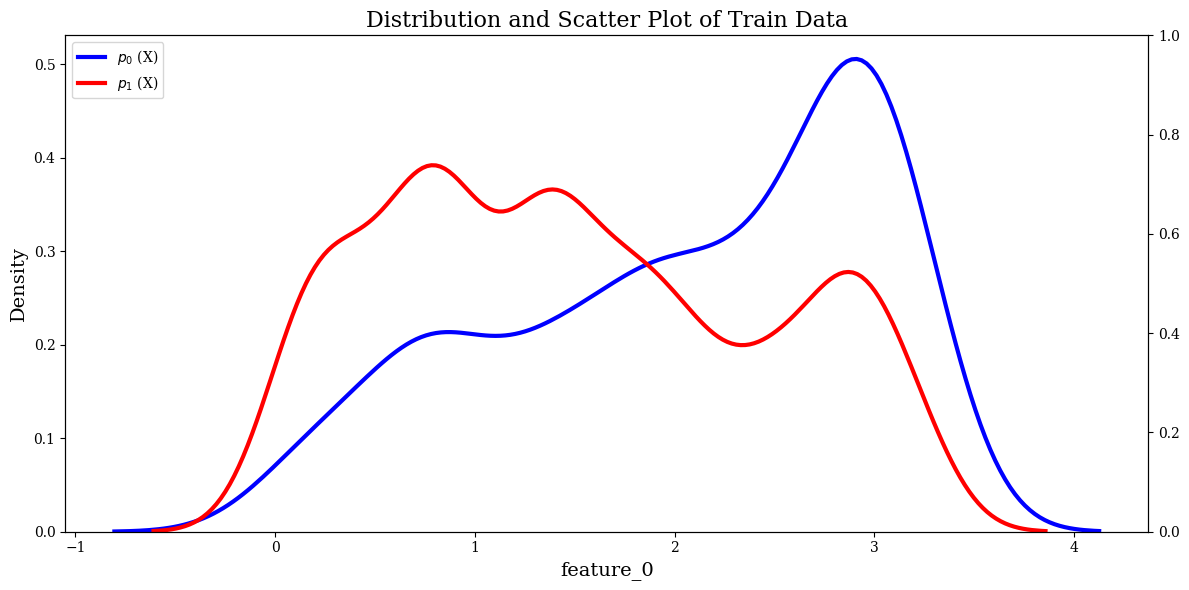

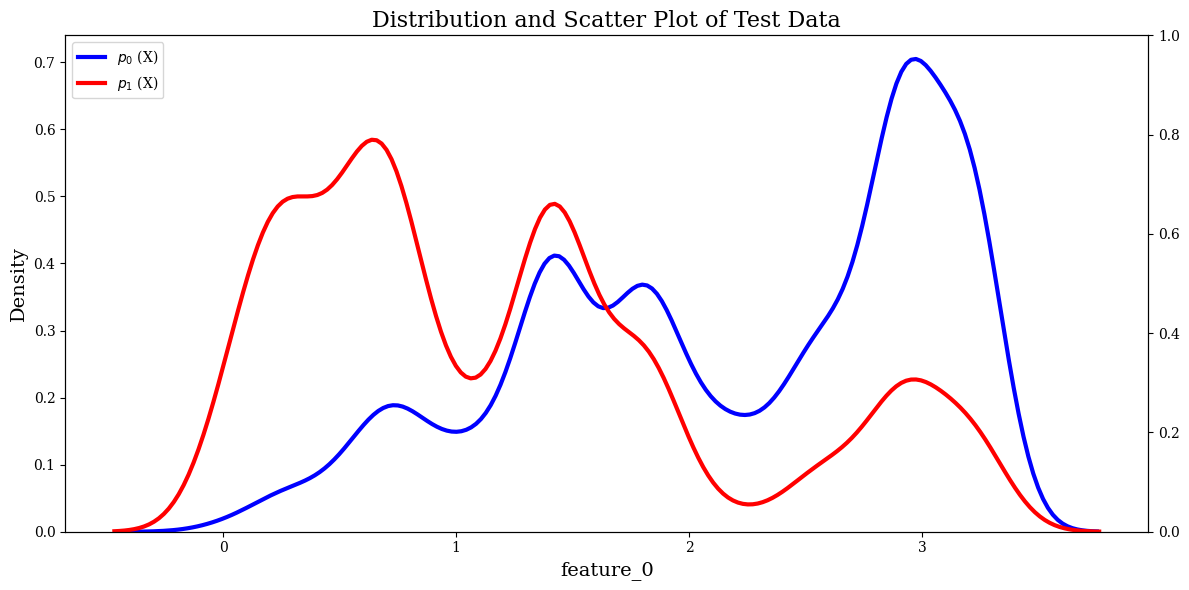

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
plt.rcParams.update({
    "font.family": "serif",
})

# Define colors for treatments
colors = ['blue', 'red']  # blue for p_0, red for p_1

def create_density_scatter_plot(data, title):
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twinx()
    
    for treatment in [0, 1]:
        subset = data[data['treatment_id'] == treatment]
        
        # Density plot for feature_0
        sns.kdeplot(data=subset, x='feature_0', ax=ax1, color=colors[treatment], 
                    linestyle='-', linewidth=3, 
                    label=r'$p_{}$ (X)'.format(treatment))
        
        # # Scatter plot
        # ax2.scatter(subset['feature_0'], subset['query_output'], 
        #             color=colors[treatment], alpha=0.3, s=10,
        #             label=r'$p_{}$ (query_output)'.format(treatment))
    
    ax1.set_xlabel("feature_0", fontsize=14)
    ax1.set_ylabel("Density", fontsize=14)
    # ax2.set_ylabel("query_output", fontsize=14)
    
    ax1.set_title(title, fontsize=16)
    
    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)
    
    plt.tight_layout()

# Create plot for train data
create_density_scatter_plot(train_df, "Distribution and Scatter Plot of Train Data")
plt.show()

# Create plot for test data
create_density_scatter_plot(test_df, "Distribution and Scatter Plot of Test Data")
plt.show()

<Axes: xlabel='query_output', ylabel='Count'>

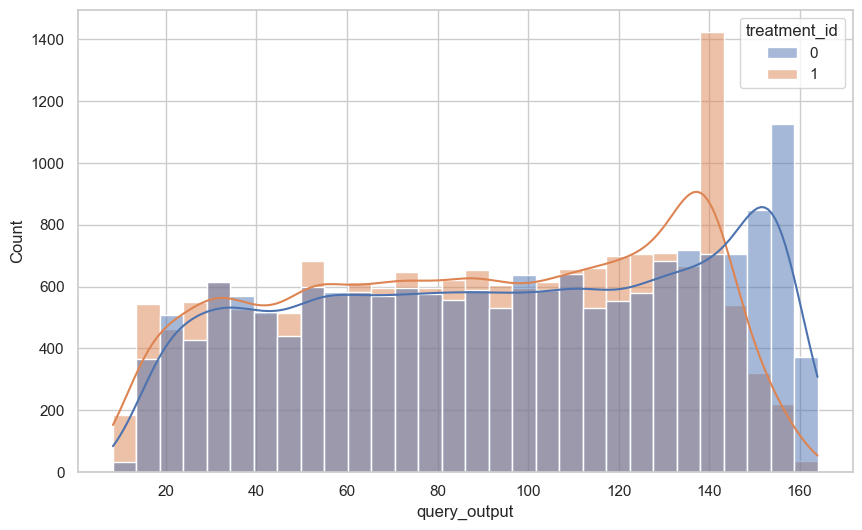

In [17]:
Y_1 = np.mean(data[data['treatment_id'] == 1]['query_output'])
Y_0 = np.mean(data[data['treatment_id'] == 0]['query_output'])

# plot the distribution of the data
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(data, x='query_output', hue='treatment_id', bins=30, kde=True)

In [9]:
sum_e_1 = 0
sum_e_0 = 0
for i in range(args.num_modules):
    # print(f"Module {i}")
    data_treatment_1 = data[(data['treatment_id'] == 1) & (data[f'num_module_{i+1}'] > 0)]
    data_treatment_0 = data[(data['treatment_id'] == 0) & (data[f'num_module_{i+1}'] > 0)]
    E_Y_1_i = np.mean(data_treatment_1[f'module_{i+1}_output'])
    E_Y_0_i = np.mean(data_treatment_0[f'module_{i+1}_output'])
    print(f"module_{i+1} E[Y_1] = {E_Y_1_i}, E[Y_0] = {E_Y_0_i}")
    sum_e_1 += E_Y_1_i
    sum_e_0 += E_Y_0_i
print(f"Sum of E[Y_1] = {sum_e_1}, E[Y_0] = {sum_e_0}")

module_1 E[Y_1] = 0.7511988074220146, E[Y_0] = 1.2141302990399152
module_2 E[Y_1] = 0.8987803679252591, E[Y_0] = 0.6763471384742122
module_3 E[Y_1] = 0.7975753967033942, E[Y_0] = 0.9289424348409615
Sum of E[Y_1] = 2.447554572050668, E[Y_0] = 2.819419872355089


In [10]:
sum_e_1 = 0
sum_e_0 = 0
for i in range(args.num_modules):
    # print(f"Module {i}")
    data_treatment_1 = data[(data['treatment_id'] == 1) & (data[f'num_module_{i+1}'] > 0)]
    data_treatment_0 = data[(data['treatment_id'] == 0) & (data[f'num_module_{i+1}'] > 0)]
    E_Y_1_i = np.mean(data_treatment_1[f'module_{i+1}_output'])
    E_Y_0_i = np.mean(data_treatment_0[f'module_{i+1}_output'])
    print(f"module_{i+1} E[Y_1] = {E_Y_1_i}, E[Y_0] = {E_Y_0_i}")
    sum_e_1 += E_Y_1_i
    sum_e_0 += E_Y_0_i
print(f"Sum of E[Y_1] = {sum_e_1}, E[Y_0] = {sum_e_0}")

module_1 E[Y_1] = 0.7511988074220146, E[Y_0] = 1.2141302990399152
module_2 E[Y_1] = 0.8987803679252591, E[Y_0] = 0.6763471384742122
module_3 E[Y_1] = 0.7975753967033942, E[Y_0] = 0.9289424348409615
Sum of E[Y_1] = 2.447554572050668, E[Y_0] = 2.819419872355089


In [12]:
for module_file, module_csv in module_csvs_test.items():
    module_id = int(module_file.split("_")[-1])
    print(f"Module {module_id}")
    pehe_score = pehe(module_csv['ground_truth_effect'], module_csv['estimated_effect'])
    print(f"PEHE: {pehe_score}")
    print(f"R2 Score: {r2_score(module_csv['ground_truth_effect'], module_csv['estimated_effect'])}")
    print("\n")

Module 1
PEHE: 8.43045680913006e-06
R2 Score: 0.9992116406238679


Module 3
PEHE: 3.409530403483242e-06
R2 Score: 0.9998127937246573


Module 2
PEHE: 2.948808966524245e-06
R2 Score: 0.9999532899051761




In [5]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# X = data[["feature_0"]].values
# T = data[treatment].values
# Y = data[outcome].values
# Y_module = data[[f"module_{i}_output" for i in range(1, args.num_modules + 1)]].values
# X_T = np.concatenate([X, T.reshape(-1, 1)], axis=1)
# X_T = torch.tensor(X_T, dtype=torch.float32).to(device)
# expert_outputs = torch.stack([expert(X_T) for expert in model.experts], dim=1)
# gate_outputs = model.gate(X_T)
# expert_gate_multiplication = expert_outputs.squeeze(-1) * gate_outputs
# print(expert_outputs.shape, Y_module.shape, expert_gate_multiplication.shape)


In [13]:
# for i in range(6):
#     data["expert_output_" + str(i)] = expert_gate_multiplication[:, i].detach().cpu().numpy()

covariates

['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5']

In [6]:
# data["final_output"] = final_output.squeeze(0).detach().cpu().numpy()

# # scatter plot for final output and query output
# plt.figure(figsize=(10, 10))
# sns.scatterplot(x="query_output", y="final_output", data=data)
# plt.xlabel("Query Output")
# plt.ylabel("Final Output")
# plt.title("Final Output vs Query Output")
# plt.show()

<AxesSubplot:xlabel='feature_0', ylabel='query_output'>

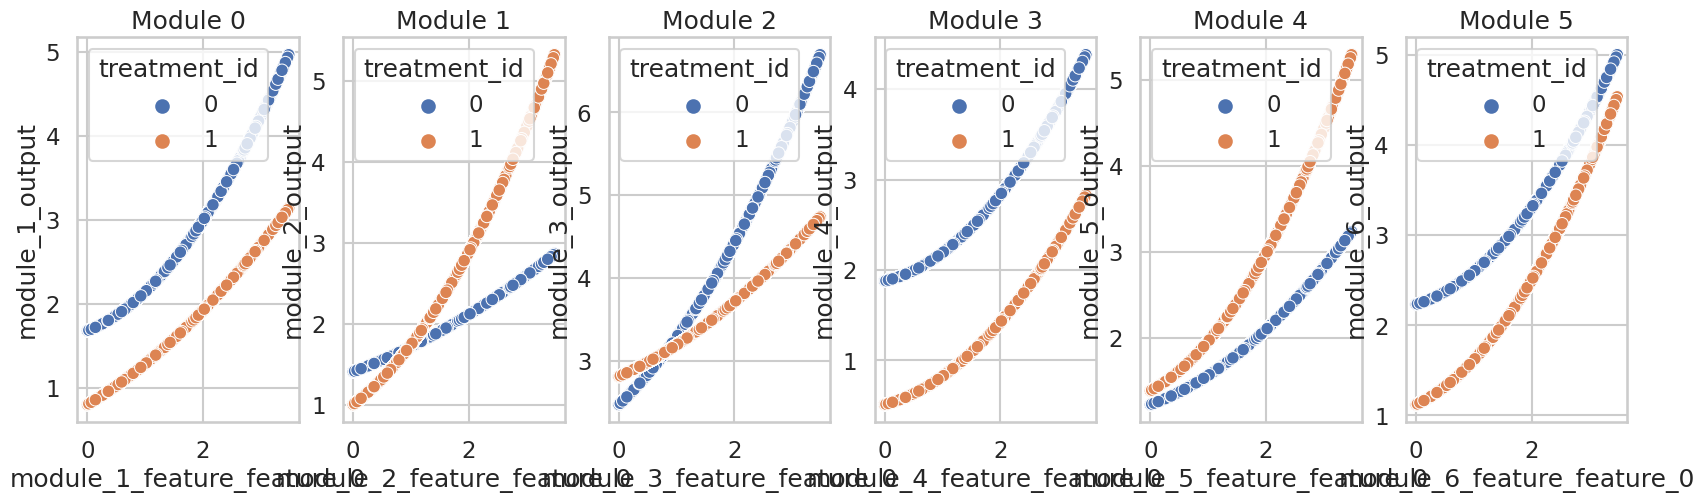

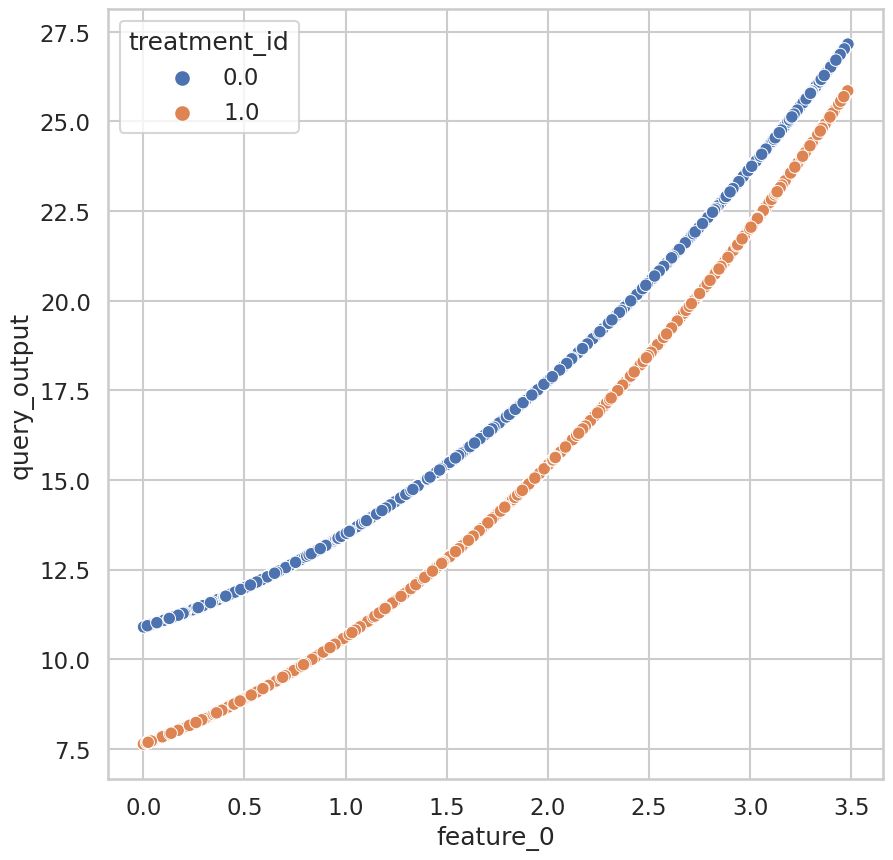

In [ ]:
# plot distribution of the covariates for train df with treatment id
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.kdeplot(data=train_df, x="feature_0", hue="treatment_id", label="Train", color="blue", ax=ax[0])
ax[0].set_title("Train Distribution")
sns.kdeplot(data=test_df, x="feature_0", hue="treatment_id", label="Test", color="red", ax=ax[1])
ax[1].set_title("Test Distribution")


plt.title("Train Distribution")
plt.show()

In [ ]:
# plot distribution of the output for train and test df in the same plot
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.histplot(train_df["query_output"], ax=ax[0], kde=True)
ax[0].set_title("Train Distribution")
sns.histplot(test_df["query_output"], ax=ax[1], kde=True)
ax[1].set_title("Test Distribution")
plt.show()

# plot distribution of the output for train and test df in the same plot
# scale the distribution by dividing by the number of samples
sns.kdeplot(train_df["query_output"], label="Train", color="blue")
sns.kdeplot(test_df["query_output"], label="Test", color="red")


plt.title("Train Distribution")
plt.show()





In [ ]:
# plot distribution of the output for train and test df in the same plot
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.histplot(train_df["query_output"], ax=ax[0], kde=True)
ax[0].set_title("Train Distribution")
sns.histplot(test_df["query_output"], ax=ax[1], kde=True)
ax[1].set_title("Test Distribution")
plt.show()

# plot distribution of the output for train and test df in the same plot
# scale the distribution by dividing by the number of samples
sns.kdeplot(train_df["query_output"], label="Train", color="blue")
sns.kdeplot(test_df["query_output"], label="Test", color="red")
plt.title("Train Distribution")
plt.show()





# Results Analysis

In [22]:
# Save results and CSVs
results_path = f"{main_dir}/results/results_{args.data_dist}_{args.module_function_type}_{args.composition_type}_covariates_shared_{args.covariates_shared}_underlying_model_{args.underlying_model_class}_use_subset_features_{args.use_subset_features}_systematic_{args.systematic}"
os.makedirs(results_path, exist_ok=True)
with open(f"{results_path}/results_{args.num_modules}_{args.num_feature_dimensions}_scale_{args.scale}.json", "w") as f:
    json.dump(results, f)



results_csv_folder = f"{main_dir}/results/csvs"
os.makedirs(results_csv_folder, exist_ok=True)
# Save combined_df_test and module_csvs here
additive_combined_test_df.to_csv(f"{results_csv_folder}/additive_combined_test_df.csv", index=False)
for module_file, module_csv in module_csvs.items():
    module_csv.to_csv(f"{results_csv_folder}/{module_file}.csv", index=False)

print(f"Results saved at {results_path}")
print(f"CSVs saved at {results_csv_folder}")
print("Done!")

2024-09-22 03:07:47.829116: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Results saved at /Users/ppruthi/research/compositional_models/compositional_models_cate/domains/synthetic_data/results/results_uniform_quadratic_parallel_covariates_shared_False_underlying_model_MLP_use_subset_features_False_systematic_False
CSVs saved at /Users/ppruthi/research/compositional_models/compositional_models_cate/domains/synthetic_data/results/csvs
Done!


In [23]:
def scatter_plot(df, x, y, title, xlabel, ylabel, save_path=None):
    plt.scatter(df[x], df[y])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if save_path:
        plt.savefig(save_path)
    plt.show()

In [24]:
combined_df_test

,ground_truth_effect,estimated_effect
0,-0.293698,-0.311285
1,-0.641127,-0.642452
2,-0.612727,-0.604818
3,0.239012,0.246677
4,-0.717167,-0.693429
...,...,...
162,-0.719175,-0.764137
163,0.595639,0.640840
164,1.285423,1.451030
165,-0.269334,-0.208952


In [16]:
## Confirming risk decomposition of the additive parallel composition model. 
results_csv_folder = f"{main_dir}/results/csvs"
# hl_filepath = f"{results_csv_folder}/combined_df_{args.data_dist}_{args.module_function_type}_{args.composition_type}_covariates_shared_{args.covariates_shared}_underlying_model_{args.underlying_model_class}_use_subset_features_{args.use_subset_features}_systematic_{args.systematic}.csv"
hl_filepath = f"{results_csv_folder}/additive_combined_test_df.csv"
combined_df_test = pd.read_csv(hl_filepath)
# drop unnamed columns

pehe_baseline_test = pehe(combined_df_test["ground_truth_effect_baseline"], combined_df_test["estimated_effect_baseline"])
pehe_additive_test = pehe(combined_df_test["ground_truth_effect_additive"], combined_df_test["estimated_effect_additive"])
pehe_moe_test = pehe(combined_df_test["ground_truth_effect_baseline"], combined_df_test["estimated_effect_moe"])

print(f"PEHE Baseline: {pehe_baseline_test}")   
print(f"PEHE Additive: {pehe_additive_test}")
print(f"PEHE MoE: {pehe_moe_test}")

# R2 score
r2_baseline_test = r2_score(combined_df_test["ground_truth_effect_baseline"], combined_df_test["estimated_effect_baseline"])
r2_additive_test = r2_score(combined_df_test["ground_truth_effect_additive"], combined_df_test["estimated_effect_additive"])
r2_moe_test = r2_score(combined_df_test["ground_truth_effect_baseline"], combined_df_test["estimated_effect_moe"])

print(f"R2 Baseline: {r2_baseline_test}")
print(f"R2 Additive: {r2_additive_test}")
print(f"R2 MoE: {r2_moe_test}")

# scatter plot
scatter_plot(combined_df_test, "ground_truth_effect_baseline", "estimated_effect_baseline", "Baseline", "Ground Truth Effect", "Estimated Effect", save_path=None)
scatter_plot(combined_df_test, "ground_truth_effect_additive", "estimated_effect_additive", "Additive", "Ground Truth Effect", "Estimated Effect", save_path=None)
scatter_plot(combined_df_test, "ground_truth_effect_baseline", "estimated_effect_moe", "MoE", "Ground Truth Effect", "Estimated Effect", save_path=None)


KeyError: 'ground_truth_effect_baseline'

# Expectation Analysis for Different Composition Models 

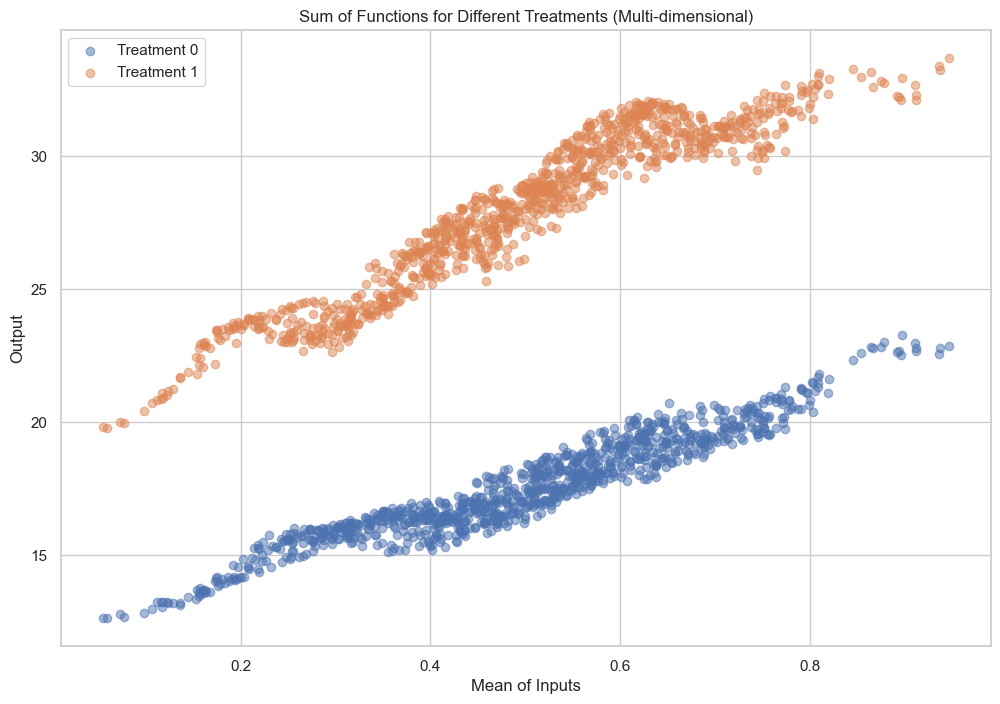

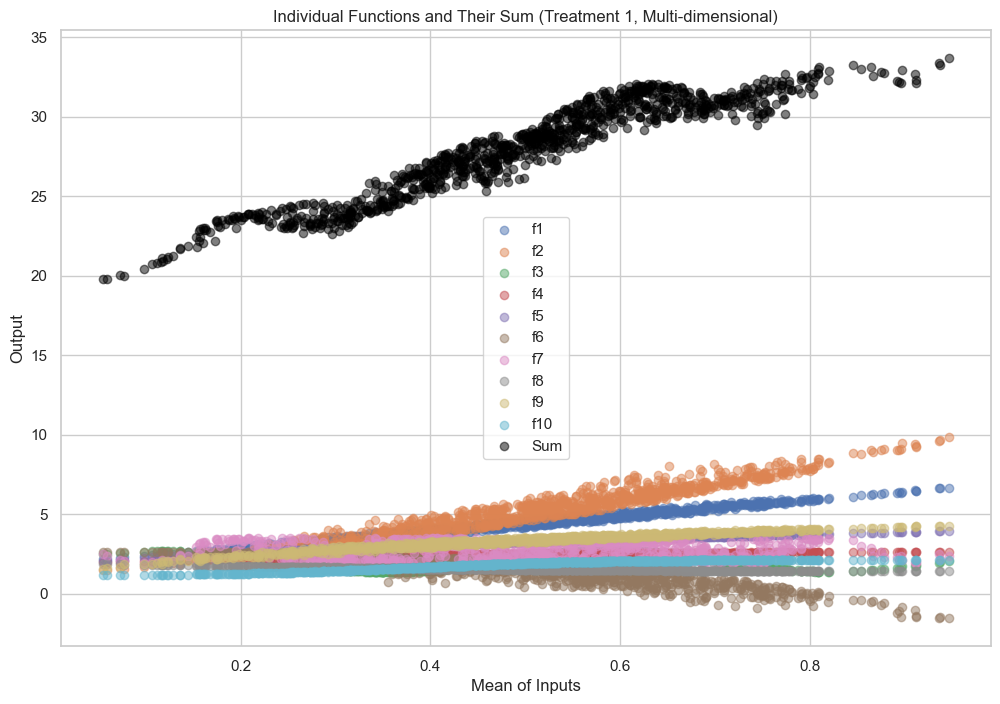

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def f1(*inputs, w):
    X = np.array(inputs)
    Mj = len(X)
    return np.dot(X, w[:Mj]) + w[-1]

def f2(*inputs, w):
    X = np.array(inputs)
    Mj = len(X)
    return np.dot(X**2, w[:Mj]) + np.dot(X, w[Mj:2*Mj]) + w[-1]

def f3(*inputs, w):
    X = np.array(inputs)
    Mj = len(X)
    return w[0] * (np.sin(np.pi * np.dot(X, w[1:Mj+1])) / 2 + 0.5) + w[-1]

def f4(*inputs, w):
    X = np.array(inputs)
    Mj = len(X)
    return w[0] / (1 + np.exp(-np.dot(X, w[1:Mj+1]))) + w[-1]

def f5(*inputs, w):
    X = np.array(inputs)
    Mj = len(X)
    return w[0] * np.sqrt(np.dot(X, w[1:Mj+1])) + w[-1]

def f6(*inputs, w):
    X = np.array(inputs)
    Mj = len(X)
    return w[0] * (1 - np.dot(X**3, w[1:Mj+1])) + w[-1]

def f7(*inputs, w):
    X = np.array(inputs)
    Mj = len(X)
    return w[0] * (0.5 * np.cos(2 * np.pi * np.dot(X, w[1:Mj+1])) + 0.5) + w[-1]

def f8(*inputs, w):
    X = np.array(inputs)
    Mj = len(X)
    return w[0] * np.exp(-np.dot(X, w[1:Mj+1])) / (1 + np.exp(-np.dot(X, w[1:Mj+1]))) + w[-1]

def f9(*inputs, w):
    X = np.array(inputs)
    Mj = len(X)
    return w[0] * np.log(np.dot(X, w[1:Mj+1]) + 1) / np.log(2) + w[-1]

def f10(*inputs, w):
    X = np.array(inputs)
    Mj = len(X)
    return w[0] * (0.5 * np.tanh(np.dot(X, w[1:Mj+1]) - 2) + 0.5) + w[-1]

def sample_weights(t, input_dim):
    np.random.seed(42)  # for reproducibility
    if t == 0:
        base = 0.5
        scale = 1.0
    else:
        base = 1.0
        scale = 1.0
    
    weights = []
    for _ in range(10):  # 10 functions
        w = np.random.uniform(base, base + scale, 2 * input_dim + 2)
        weights.append(w)
    
    return weights

def sum_function(inputs, weights):
    return sum(f(*inputs, w=w) for f, w in zip([f1, f2, f3, f4, f5, f6, f7, f8, f9, f10], weights))

# Generate multi-dimensional inputs
input_dim = 3  # Change this to adjust the number of input dimensions
num_samples = 1000
inputs = np.random.rand(num_samples, input_dim)

# Plot functions for both treatments
plt.figure(figsize=(12, 8))

for t in [0, 1]:
    weights = sample_weights(t, input_dim)
    y = [sum_function(input_row, weights) for input_row in inputs]
    plt.scatter(np.mean(inputs, axis=1), y, alpha=0.5, label=f'Treatment {t}')

plt.xlabel('Mean of Inputs')
plt.ylabel('Output')
plt.title('Sum of Functions for Different Treatments (Multi-dimensional)')
plt.legend()
plt.grid(True)
plt.show()

# Plot individual functions for a specific treatment
t = 1  # Change this to 0 or 1 to see different treatments
weights = sample_weights(t, input_dim)

plt.figure(figsize=(12, 8))
for i, func in enumerate([f1, f2, f3, f4, f5, f6, f7, f8, f9, f10]):
    y = [func(*input_row, w=weights[i]) for input_row in inputs]
    plt.scatter(np.mean(inputs, axis=1), y, alpha=0.5, label=f'f{i+1}')

y_sum = [sum_function(input_row, weights) for input_row in inputs]
plt.scatter(np.mean(inputs, axis=1), y_sum, alpha=0.5, label='Sum', color='black')
plt.xlabel('Mean of Inputs')
plt.ylabel('Output')
plt.title(f'Individual Functions and Their Sum (Treatment {t}, Multi-dimensional)')
plt.legend()
plt.grid(True)
plt.show()

# Data Analysis

# Data baseline model 

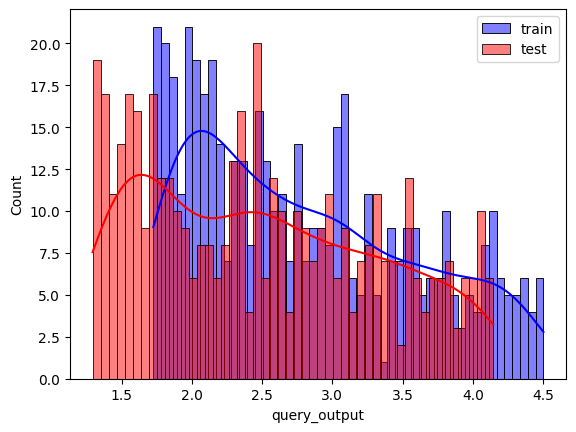

In [3]:
# plot feature distribution of module_1_feature_feature_0
import seaborn as sns
# sns.histplot(train_df[high_level_output], bins=50, color="blue", label="train", kde=True)
# sns.histplot(test_df[high_level_output], bins=50, color="red", label="test", kde=True)

# have two histograms based on treatment
sns.histplot(train_df[train_df["treatment_id"]==0]["query_output"], bins=50, color="blue", label="train", kde=True)
sns.histplot(train_df[train_df["treatment_id"]==1]["query_output"], bins=50, color="red", label="test", kde=True)

plt.legend()




# sns.histplot(data[high_level_output], bins=50, color="green")

NameError: name 'baseline_combined_df' is not defined

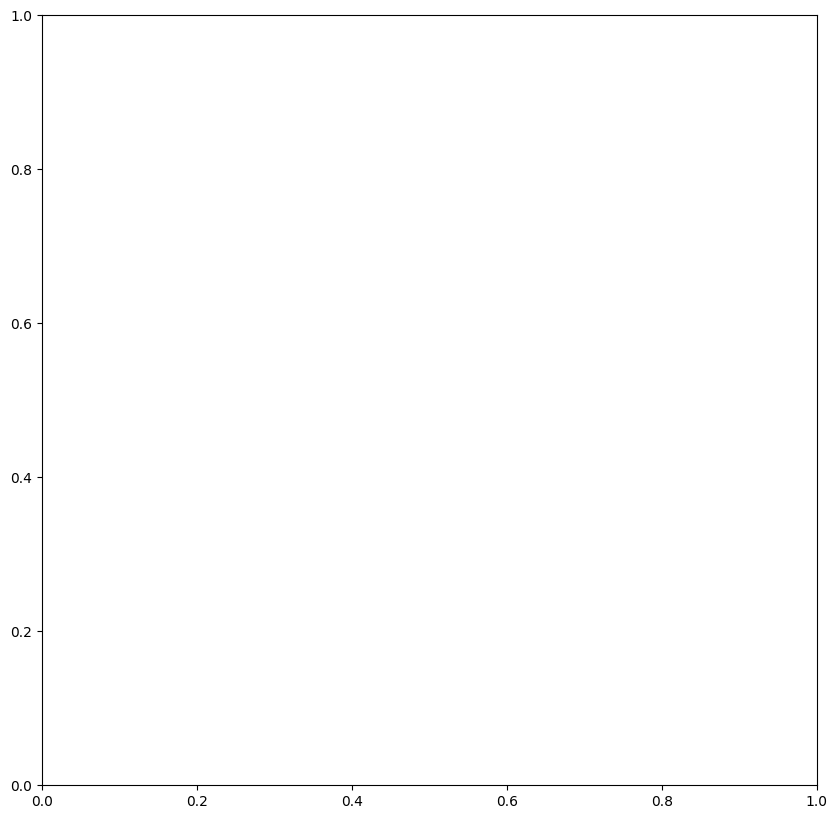

In [4]:
# scatter plot of ground truth vs estimated effects
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(x="ground_truth_effect", y="estimated_effect", data=baseline_combined_df, ax=ax)
ax.set_xlabel("Ground Truth Effect")
ax.set_ylabel("Estimated Effect")
ax.set_title("Ground Truth vs Estimated Effects")

plt.show()

